In [1]:
PATH = "moments_accountant_v1"

In [2]:
import tensorflow as tf
import sys
import os
sys.path.append("../")

from federated.data.data_preprocessing import load_data
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
import pandas as pd

pd.options.plotting.backend = "plotly"

%matplotlib inline

In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
"""
Function that evaluates the model.
Prints accuracy and loss value
"""
def evaluation(X, y, model):
    scores = model.evaluate(X, y, verbose=0)
    print(f"Accuracy: {scores[1]*100}%, Loss: {scores[0]}")

In [5]:
LABELS = ["N", "S", "V", " F", "U"]

In [6]:
"""
Function that creates confusion matrix based upon the dataset and the model.
Displays the confusion matrix.
"""

def make_confusion_matrix(X,y, model):
    y_pred = model.predict(X)
    y_test = np.argmax(y, axis=1)
    y_pred = np.argmax(y_pred, axis=1)

    cnf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(15,15))
    cnf_matrix =  cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(LABELS))
    plt.xticks(ticks, LABELS, rotation=45)
    plt.yticks(ticks, LABELS)

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j,i,format(cnf_matrix[i,j], '.2f'), horizontalalignment="center",
                    color="white" if cnf_matrix[i, j] > cnf_matrix.max()/2 else "black")

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


    plt.show()

    return y_test, y_pred

In [7]:
"""
Function that loads model and dataset for analysis
Returns x_test, y_test and model
"""
def load(name):
    model = tf.keras.models.load_model("../history/logdir/" + name)
    X_test, y_test = load_data(data_analysis=True)

    X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
    evaluation(X_test, y_test, model)
    
    return X_test, y_test, model

In [36]:
def dataframe_from_event(path, type, moments=False):

    path += f"{type}/"
    event_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    event_files = list(filter(lambda f: "empty" not in f, event_files))
    path += event_files[0]

    if moments:
        condition = lambda x : "privacy_loss" in x
    else:
        condition = lambda x : "loss" in x or "accuracy" in  x

    metrics = defaultdict(list)
    for e in summary_iterator(path):
        for v in e.summary.value:
            if isinstance(v.simple_value, float) and condition(v.tag):
                if v.simple_value == 0.0:
                    metrics[f"{v.tag}_{type}"].append(tf.make_ndarray(v.tensor))
                else:
                    metrics[f"{v.tag}_{type}"].append(v.simple_value)
    metrics_df = pd.DataFrame({k: v for k,v in metrics.items() if len(v) > 1})

    return metrics_df

In [42]:
def plot_graph(type, moments=False):
    
    if type not in ["accuracy", "loss", "moments_accountant"]:
        raise ValueError(f"type must be accuracy or loss, not {type}")

    path = f"../history/logdir/{PATH}/"
    if moments:
        moments_df = dataframe_from_event(path, type)
        moments_df= moments_df.rename(columns={"cumulative_privacy_loss_moments_accountant": "cumulative_privacy_loss"})
        return moments_df
    else:
        train_df = dataframe_from_event(path, "train")
        validation_df = dataframe_from_event(path, "validation")

        cols = list(train_df.columns) + list(validation_df.columns)

        return pd.concat([train_df, validation_df], axis=1)[[col for col in cols if type in col]]

In [43]:
X_test, y_test, model_centralized = load(PATH)

Accuracy: 70.57372331619263%, Loss: 0.9702852964401245


In [44]:
model_centralized.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 186)               0         
_________________________________________________________________
dense_64 (Dense)             (None, 50)                9350      
_________________________________________________________________
dense_65 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_66 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_67 (Dense)             (None, 5)                 255       
Total params: 14,705
Trainable params: 14,705
Non-trainable params: 0
_________________________________________________________________


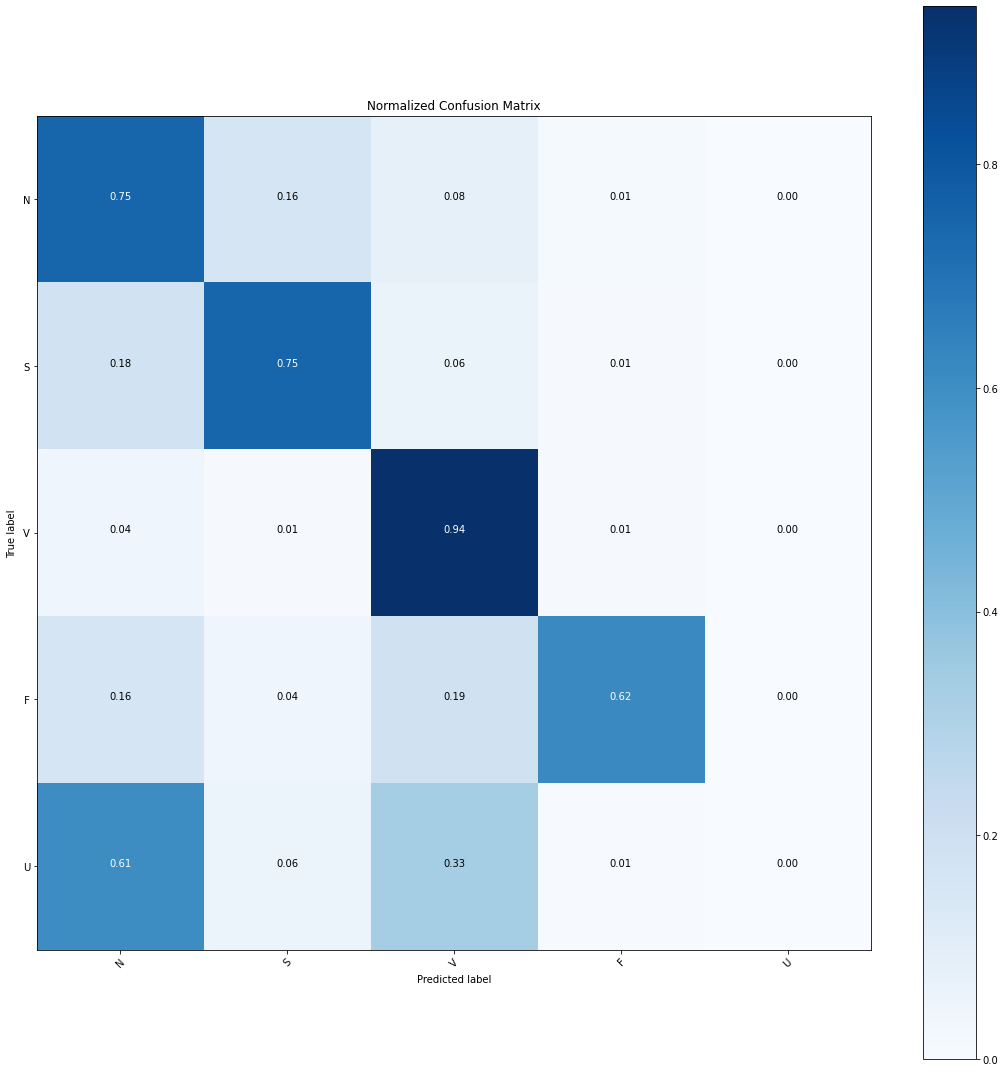

In [45]:
y_test, y_pred = make_confusion_matrix(X_test, y_test, model_centralized)

In [46]:
print(classification_report(y_test, y_pred, target_names=LABELS))

              precision    recall  f1-score   support

           N       0.92      0.75      0.83     18118
           S       0.12      0.75      0.21       556
           V       0.40      0.94      0.56      1448
           F       0.30      0.62      0.41       162
           U       0.00      0.00      0.00      1608

    accuracy                           0.71     21892
   macro avg       0.35      0.61      0.40     21892
weighted avg       0.79      0.71      0.73     21892

/home/dilawar/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/dilawar/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to

In [47]:
metrics_df = plot_graph("accuracy")
metrics_df.plot(title="Epoch Accuracy", labels=dict(index="epochs", value="accuracy", variable="option"))

In [48]:
metrics_df = plot_graph("loss")
metrics_df.plot(title="Epoch Loss", labels=dict(index="epochs", value="loss", variable="option"))

In [49]:
metrics_df = plot_graph("moments_accountant", moments=True)
metrics_df.plot(title="Moments Accountant", labels=dict(index="epochs", value="epsilon", variable="option"))